# Imports 

In [48]:
#%matplotlib inline
import os, sys
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats
import pickle
import sklearn.decomposition
import sklearn.cluster
import matplotlib.cm
import importlib
from matplotlib import animation
from IPython.display import HTML
import seaborn as sns 
from statsmodels.tsa.stattools import ccf, acf, pacf
from scipy.stats import zscore, norm, kurtosis
from scipy import signal

# Helper functions

In [45]:
def Cluster_splitter(spks:np.array, xpos:np.array, ypos:np.array, labels:np.array, xmin:int, xmax:int, zcored:bool = True):

    """ 
    This function takes the original neuron x time matrix and constructs an object that cointain 
    each subset of neurons per cluster

    Parameters
    ----------

    spks : np.array
        Array to be splitted (original neuron x time array)
    xpos : np.array 
        Array of x positions to be splitted
    ypos : np.array 
        Array of y positions to be splitted
    labels : np.array 
        Array containing the labels of the neurons (output of the clustering algorithm)
    xmin : int
        Initial offset 
    xmax : int 
        Final offset
    zcored : bool
        Boolean flag to indicate if the returned value should be zcored 

    Returns
    ----------
    splitted_spks: np.array
        numpy object that contains each cluster subset per entry
    splitted_xpos: np.array
        numpy object that contains each xposition coordinate per cluster subset, per entry
    splitted_ypos: np.array
        numpy object that contains each yposition coordinate per cluster subset, per entry
    """

    clusters = np.unique(labels)
    splitted_spks = np.empty(len(clusters),dtype=object)
    splitted_xpos = np.empty(len(clusters),dtype=object)
    splitted_ypos = np.empty(len(clusters),dtype=object)
    splitted_sn = np.empty(len(clusters),dtype=object)
    if xmax == None:
        xmax = spks.shape[1]
    for clust in clusters:
        selector = np.where(labels==clust)[0]
        if zcored == False:
            selected_spks = spks[selector,xmin:xmax]
        else:
            selected_spks = zscore(spks[selector,xmin:xmax], axis = 1)
        
        splitted_xpos[clust] = xpos[selector]
        splitted_ypos[clust] = ypos[selector]
        splitted_spks[clust] = selected_spks
        splitted_sn[clust] = Get_superneuron(selected_spks)
    return splitted_spks, splitted_xpos, splitted_ypos, splitted_sn

def Get_superneuron(cluster: np.array):

    """ 
    Computes the mean over all neurons in the cluster 

    Parameters
    ----------

    cluster : np.array
        Array containing the neurons in a given cluster

    Returns
    ----------
        numpy array containg the mean over all neurons in the cluster
    """

    return cluster.mean(axis=0)


def ClusterVisualizer(selected_spks:np.array):
    """
    Simple cluster visualizer (neurons x time) and superneuron

    Parameters
    ----------
    selected_spks: np.array
        Array cointaing the cluster to be visualized
    """

    f, (ax1,ax2) = plt.subplots(2,1,sharex=True, figsize=(10,10), dpi=150)
    ax1.imshow(selected_spks, vmin=0, vmax=2, cmap='gray_r', aspect='auto')
    ax1.set_ylabel('neuron (id)')
    ax2.plot(Get_superneuron(selected_spks), color= 'k')
    ax2.set_title('SuperNeuron activity')
    ax2.set_ylabel('Activity (a.u)')
    ax2.set_xlabel('time $(ms)$')
    sns.despine()

def Get_ACF_PACF(superneuron:np.array, lags:int=30):

    """
    Gets the autocorr and partial autocorr of the superneuron 

    Parameters
    ----------
    superneuron: np.array
        Array cointaing superneuron activity
    lags: int
        number of lags to be computed
    Returns:
    ----------

    sn_acf: np.array
        Array containing the autocorrelation of the superneuron activity
    sn_pacf: np.array
        Array containing the partial autocorrelation of the superneuron activity  
    """
    sn_acf = acf(superneuron, nlags=lags, fft=True)
    sn_pacf= pacf(superneuron, nlags=lags)

    return sn_acf,sn_pacf

def ACFViz(superneuron:np.array, acf:np.array, pacf:np.array, alpha=0.025):
    

    """
    Plots the autocorrelation and partial autocorrelation of the signal with CI for a given alpha

    Parameters
    ----------
    superneuron: np.array
        Array cointaing superneuron activity
    acf: np.array
        Array containing the autocorrelation of the superneuron activity
    pacf: np.array
        Array containing the partial autocorrelation of the superneuron activity  
    alpha: Two tailed (!!) confidence value at 95% 
    """

    quantile = norm.ppf(1-alpha)
    ac_se = np.sqrt(1+(2*np.sum(acf**2)))
    acf_ci = quantile * ((ac_se)/np.sqrt(len(superneuron)))
    pacf_ci = quantile / np.sqrt(len(superneuron))
    f, (ax1,ax2) = plt.subplots(2,1,sharex=True, figsize=(10,10), dpi=150)
    
    ax1.stem(acf)
    ax1.axhline(y=acf_ci,linestyle='--',color='gray', label=f"{(1 - (alpha*2))*100} % Confidence interval")
    ax1.axhline(y=-acf_ci,linestyle='--',color='gray')
    ax1.set_ylabel('Autocorrelation')
    ax1.legend()

    ax2.stem(pacf)
    ax2.axhline(y=pacf_ci,linestyle='--',color='gray')
    ax2.axhline(y=-pacf_ci,linestyle='--',color='gray')
    ax2.set_ylabel('Partial Autocorrelation')
    ax2.set_xlabel('Lags')
    sns.despine()

def Get_CCF(Splitted_spks:np.array, cluster_ref:int, cluster_comp:int):

    """
    Computes the crosscorrelation between two superneurons


    Parameters:
    -----------

    Splitted_spks: np.array
        numpy object that contains each cluster subset per entry
    cluster_ref: int
        label of the reference cluster
    cluster_comp: int
        label of the compared cluster

    Returns:
    ----------
    full: np.array
        full crosscorrelogram between the two signals, reference vs comparison in the positive lags 
        and comparison vs reference in the negative lags
    a: np.array
        crosscorrelogram between the reference and comparison signal (positive lags part of the full vector)
    b: np.array
        crosscorrelogram between the comparison and reference signal (negative lags part of the full vector)
    """
    sn0 = zscore(Get_superneuron(Splitted_spks[cluster_ref]))
    sn1 = zscore(Get_superneuron(Splitted_spks[cluster_comp]))
    a = ccf(sn0,sn1,adjusted=False,fft=True)
    b = ccf(sn1,sn0,adjusted=False,fft=True)
    c= b[::-1]
    full = np.append(c,a)
    return full, a, b

def plot_ccf(ccf: np.array):


    """
    Plots the crosscorrelagram given the ccf vector


    Parameters:
    -----------

    ccf: np.array
        full ccf vector
    """

    plt.figure(figsize=(16,9), dpi=150)
    x = np.arange(-((ccf.shape[0]+1)/2)+1,(ccf.shape[0])/2)
    plt.axhline(y=0,linestyle='-',color='red',linewidth=3)
    plt.plot(x,ccf,color='k')
    plt.ylabel('Cross-correlation')
    plt.xlabel('Lags')
    sns.despine()

# Data loading
## Spike extraction

In [3]:
data_root = '/home/mano/Documents/Profesional Projects/Raster_tuto/spont'
video_root = '/home/mano/Documents/Profesional Projects/Raster_tuto/spont/cam/'

dbs = {'mouse_name': 'TX60', 'date': '2020_10_20', 'exp': '2', 'cam': ['0', '1']}

In [20]:
dat = np.load(os.path.join(data_root, 'spont_2cam_%s_%s.npz'%
                  (dbs['mouse_name'], dbs['date'])))

spks = dat['spks'].astype(np.float32)
ypos = dat['ypos'].astype(np.float32)
xpos = dat['xpos'].astype(np.float32)

Exploring the `npz` data structure:

In [4]:
dat.files

['spks', 'tcam', 'ypos', 'xpos', 'tneural', 'run']

In [5]:
spks.shape

(42568, 23185)

(neurons) x n_samples

## spike normalization

In [5]:
spks -= spks.mean(axis=1)[:,np.newaxis]
spks /= ((spks**2).mean(axis=1)**0.5)[:,np.newaxis]

# Rastermap fit

In [6]:
sys.path.insert(0, '/home/mano/Documents/Profesional Projects/RasterMap')
from rastermap import mapping

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [55]:
n_clusters = 100 

In [7]:
RM_model = mapping.Rastermap(smoothness=1, 
                           n_clusters=n_clusters, 
                           n_PCs=128, 
                           ts=0.9,
                           time_lag_window=0,
                           grid_upsample=10,
                           n_splits=0).fit(spks, normalize=False) # (we've already normalized)

n_PCs = 128 computed, time 28.35
landmarks computed and embedded, time 49.59
grid upsampled, time 52.34


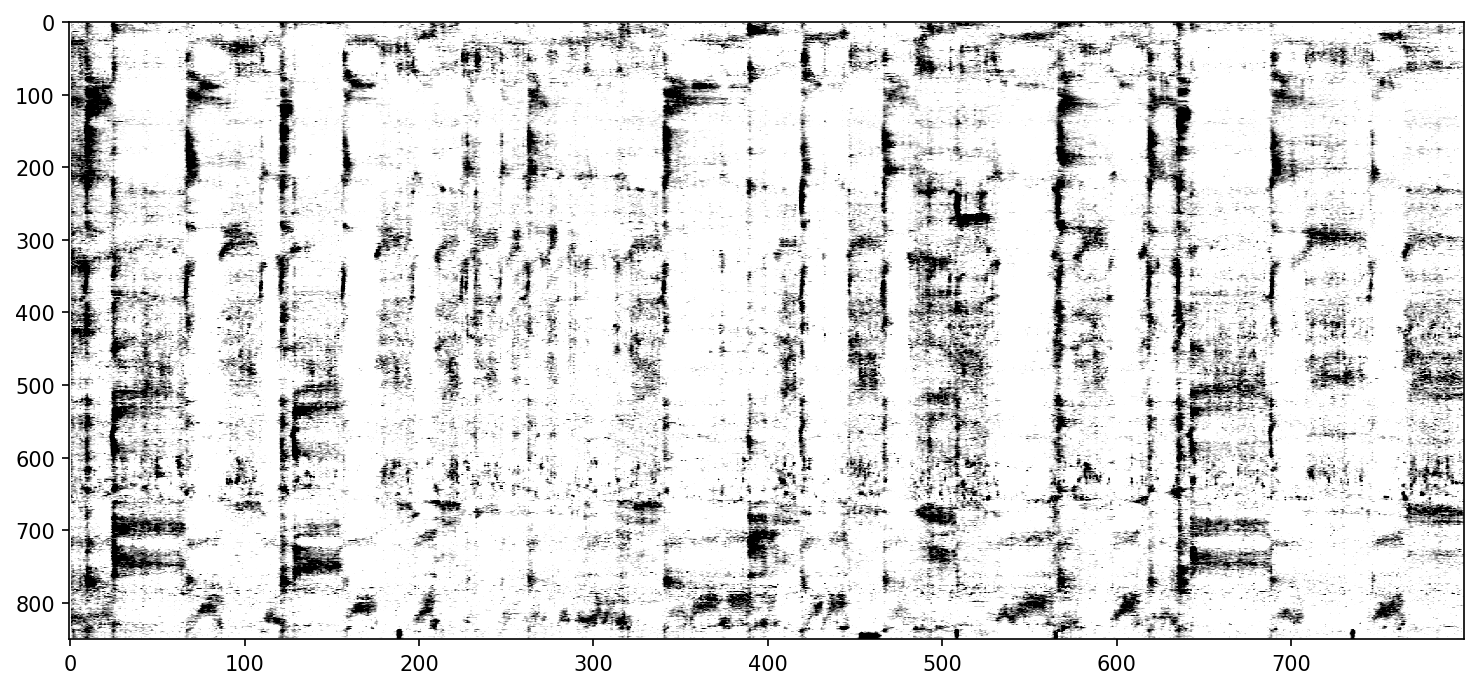

In [8]:
from scipy.stats import zscore
plt.figure(figsize=(12,12), dpi=150)
xmin=0
xmax=xmin+800
plt.subplot(2,1,1)
plt.imshow(zscore(RM_model.X_embedding[:,xmin:xmax], axis=1), vmin=0, vmax=2, cmap='gray_r', aspect='auto')

# Rastermap cluster inspection 

In [46]:
Splitted_spks, Splitted_xpos, Splitted_ypos, Splitted_sn = Cluster_splitter(spks, xpos, ypos, 
                                labels=RM_model.embedding_clust, 
                                xmin = 0, 
                                xmax = 800)

# Timescales

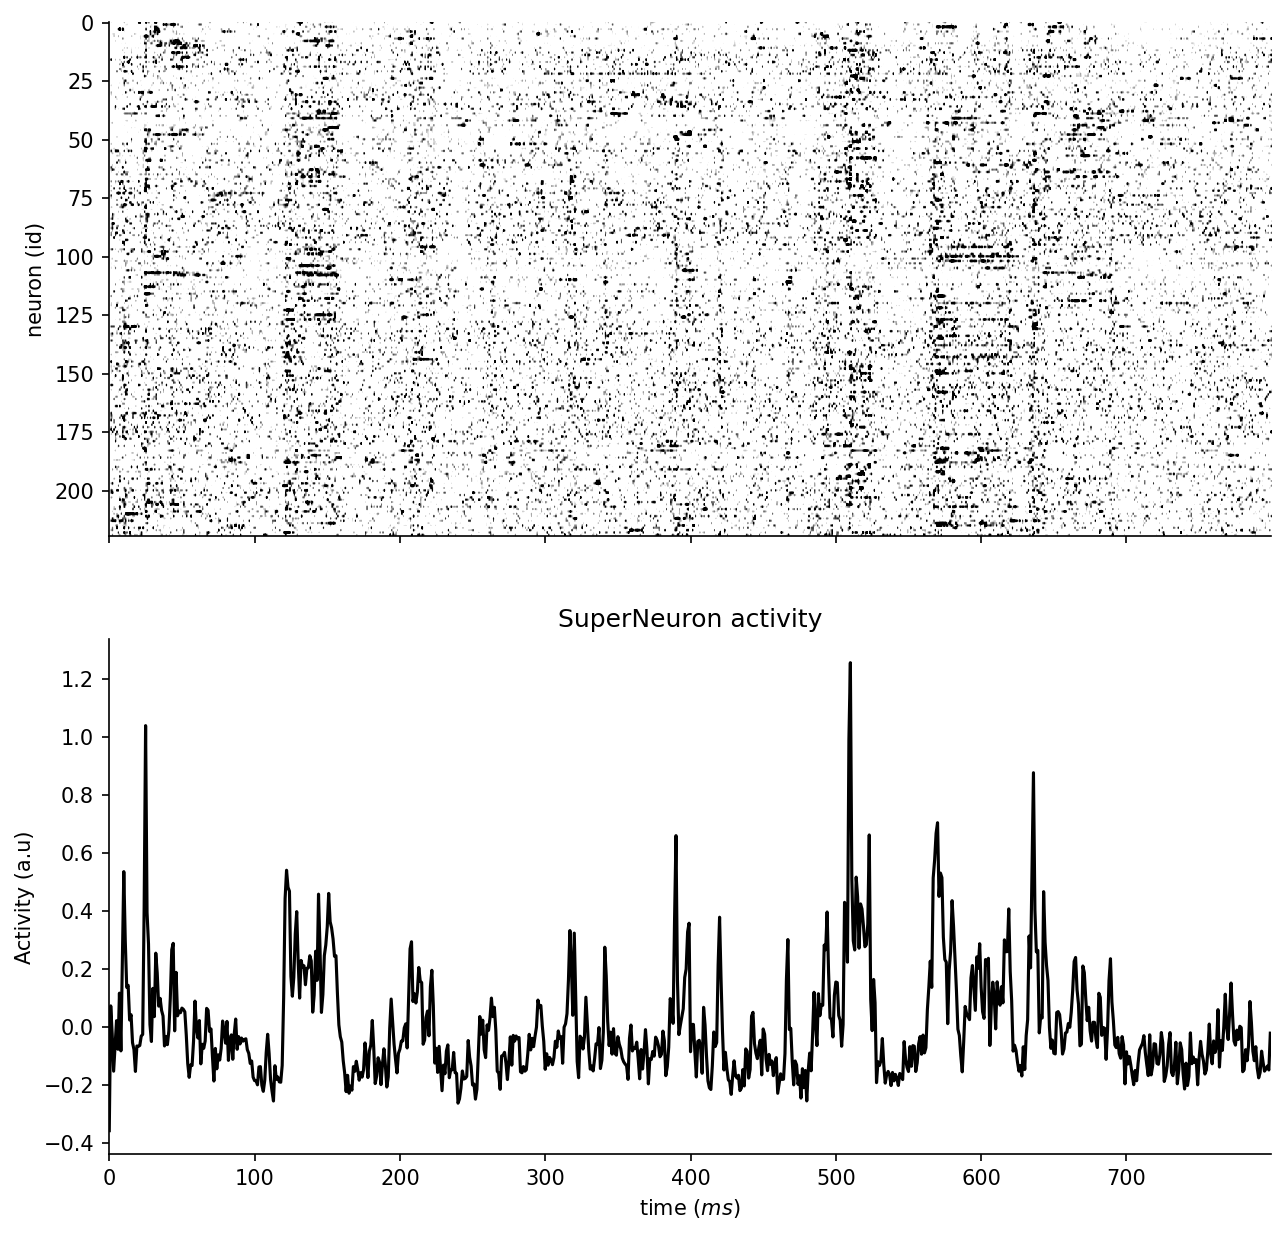

In [10]:
Cluster0 = Splitted_spks[0]
ClusterVisualizer(Cluster0)

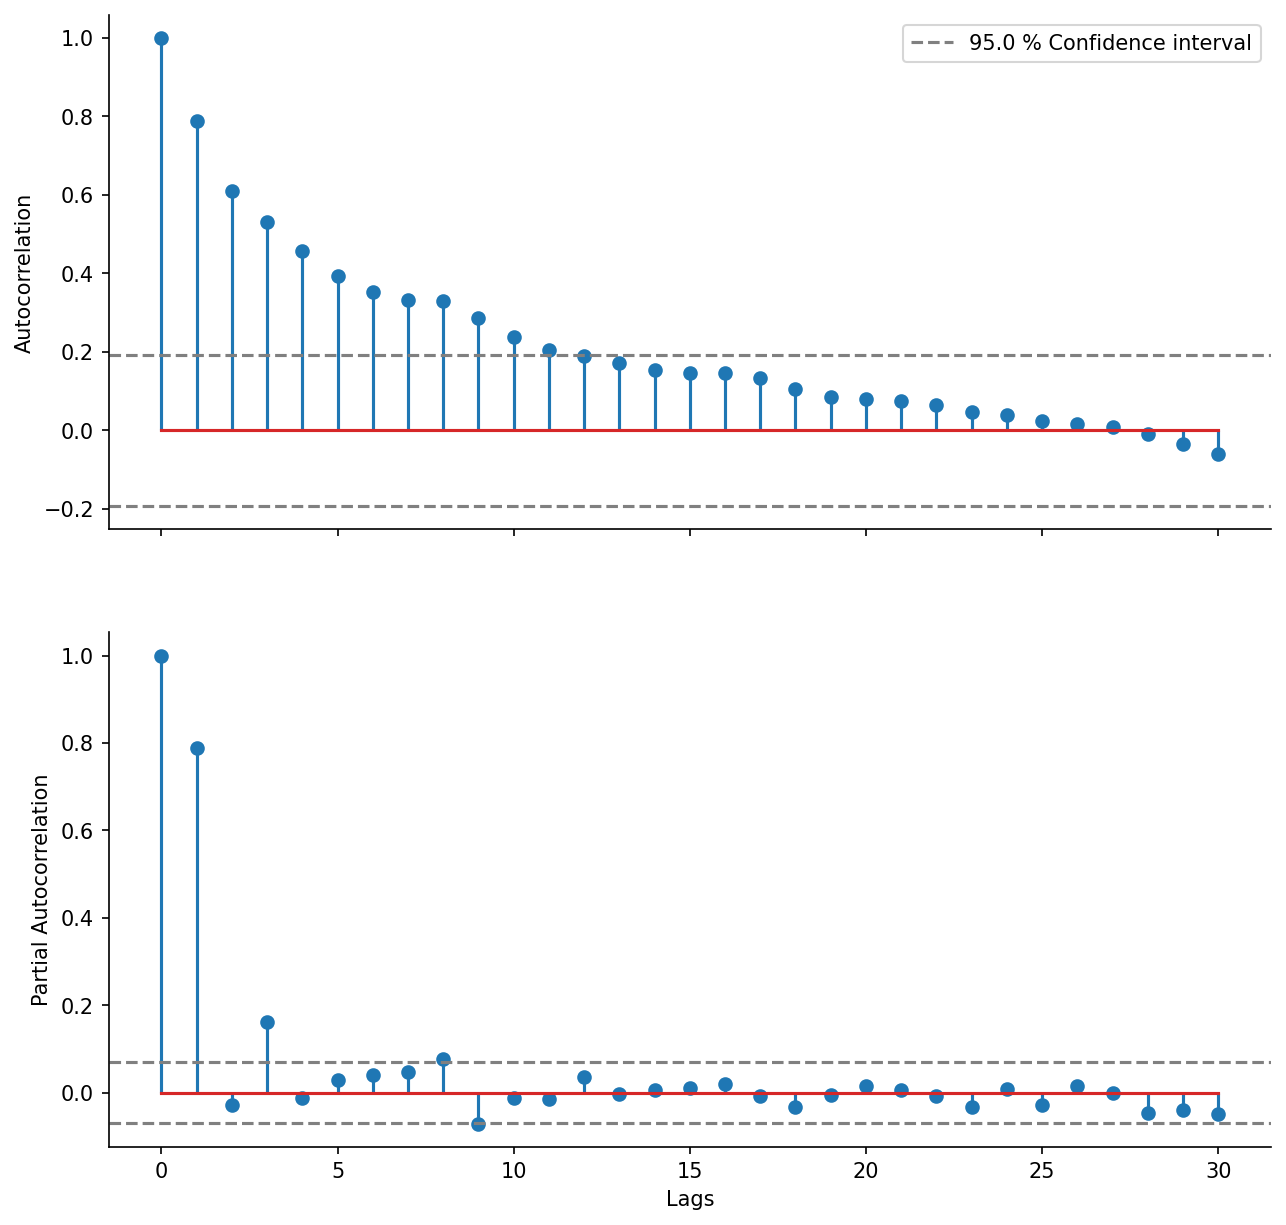

In [15]:
sn0 = Get_superneuron(Cluster0)
sn0_acf, sn0_pacf = Get_ACF_PACF(sn0)
ACFViz(sn0,sn0_acf,sn0_pacf)

In [100]:
alpha = 0.025
quantile = norm.ppf(1-alpha)
ac_se = np.sqrt(1+(2*np.sum(sn0_acf**2)))
acf_ci = quantile * ((ac_se)/np.sqrt(len(sn0)))

print(sn0_acf[sn0_acf>acf_ci])

decayment = sn0_acf[sn0_acf>acf_ci][-1] 

decay_perlag = decayment/ len(sn0_acf[sn0_acf>acf_ci]) 

decay_perlag


[1.         0.78776041 0.60953047 0.53177766 0.45794003 0.39288222
 0.35376782 0.33167948 0.32928569 0.28715511 0.23864856 0.20497189]


0.01708099064536191

In [95]:
from scipy.stats import expon
expon.fit(sn0_acf[sn0_acf>acf_ci])

(0.2049718877443429, 0.255478058451849)

<StemContainer object of 3 artists>

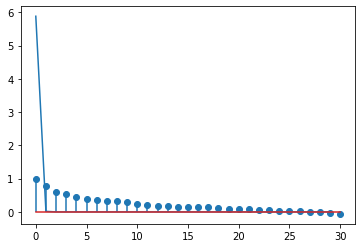

In [102]:
plt.plot(expon.pdf(np.arange(30),0,.17))
plt.stem(sn0_acf)

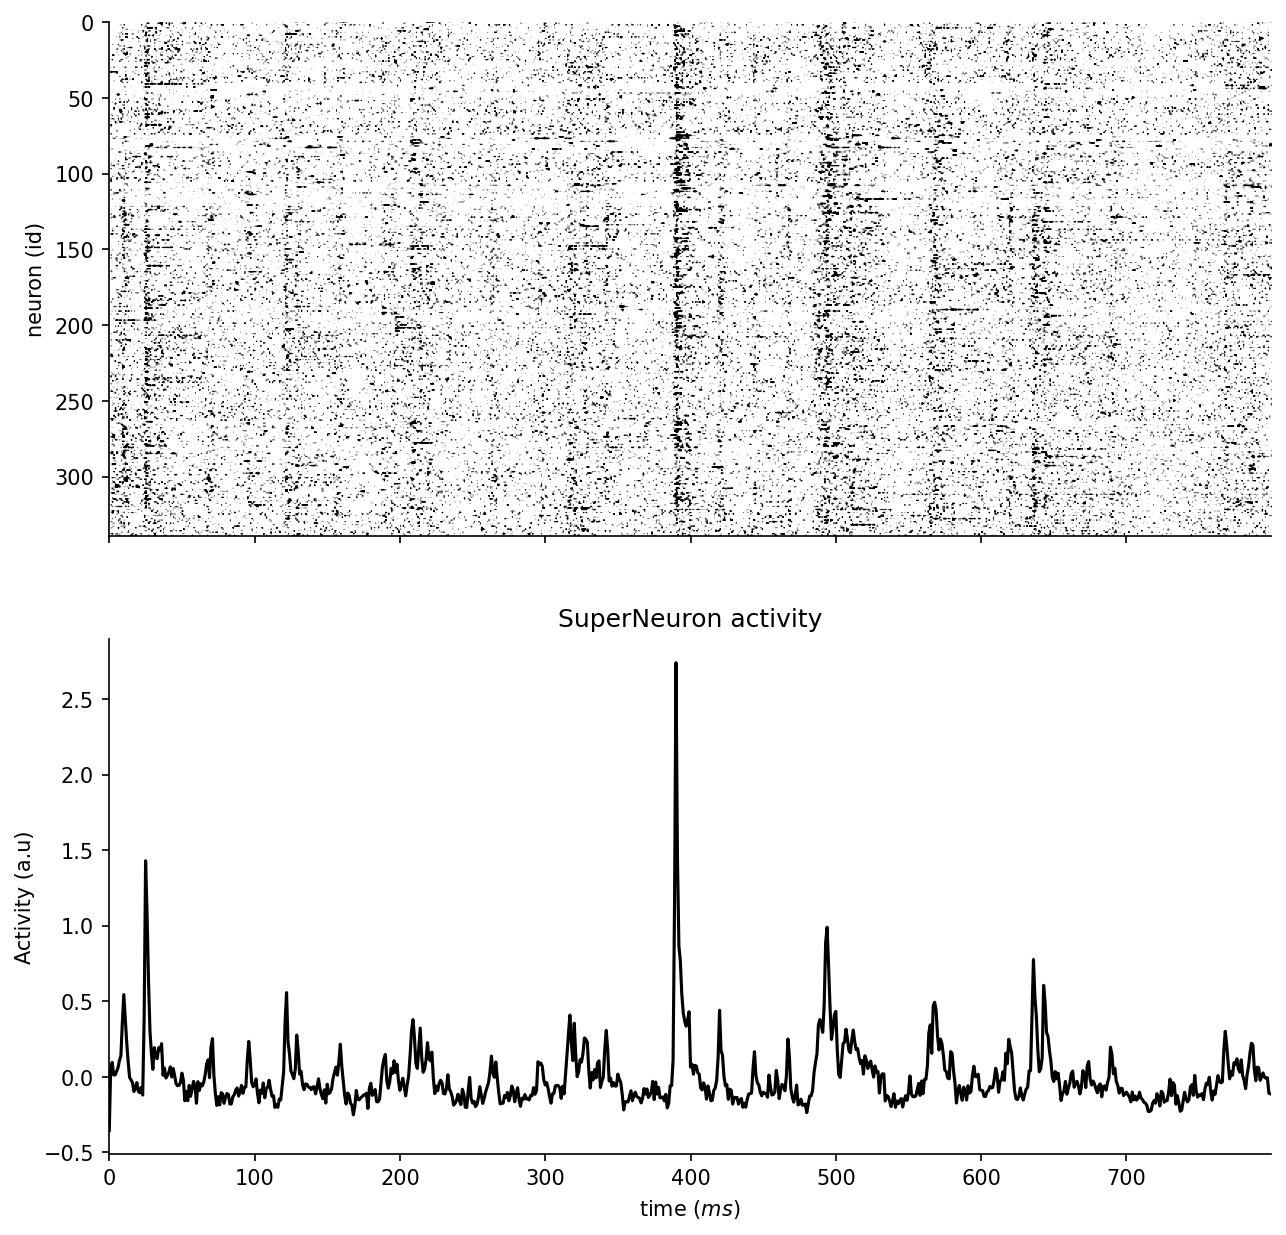

In [16]:
Cluster1 = Splitted_spks[1]
ClusterVisualizer(Cluster1)

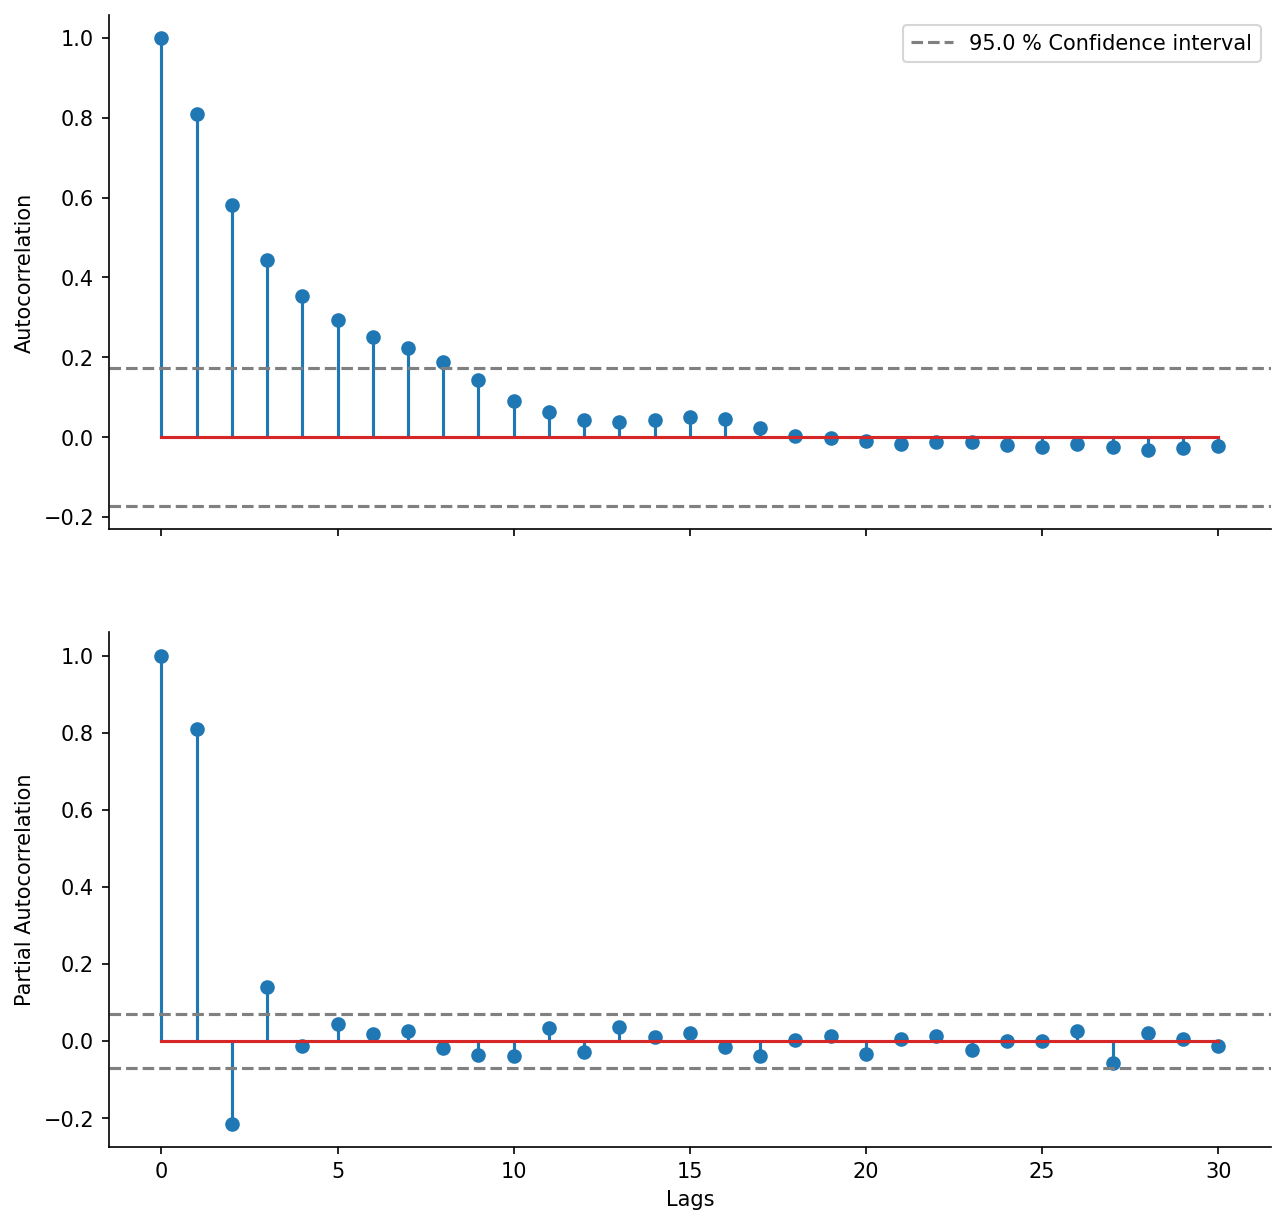

In [35]:
sn1 = Get_superneuron(Cluster1)
sn1_acf, sn1_pacf = Get_ACF_PACF(sn1)
ACFViz(sn1,sn1_acf,sn1_pacf)

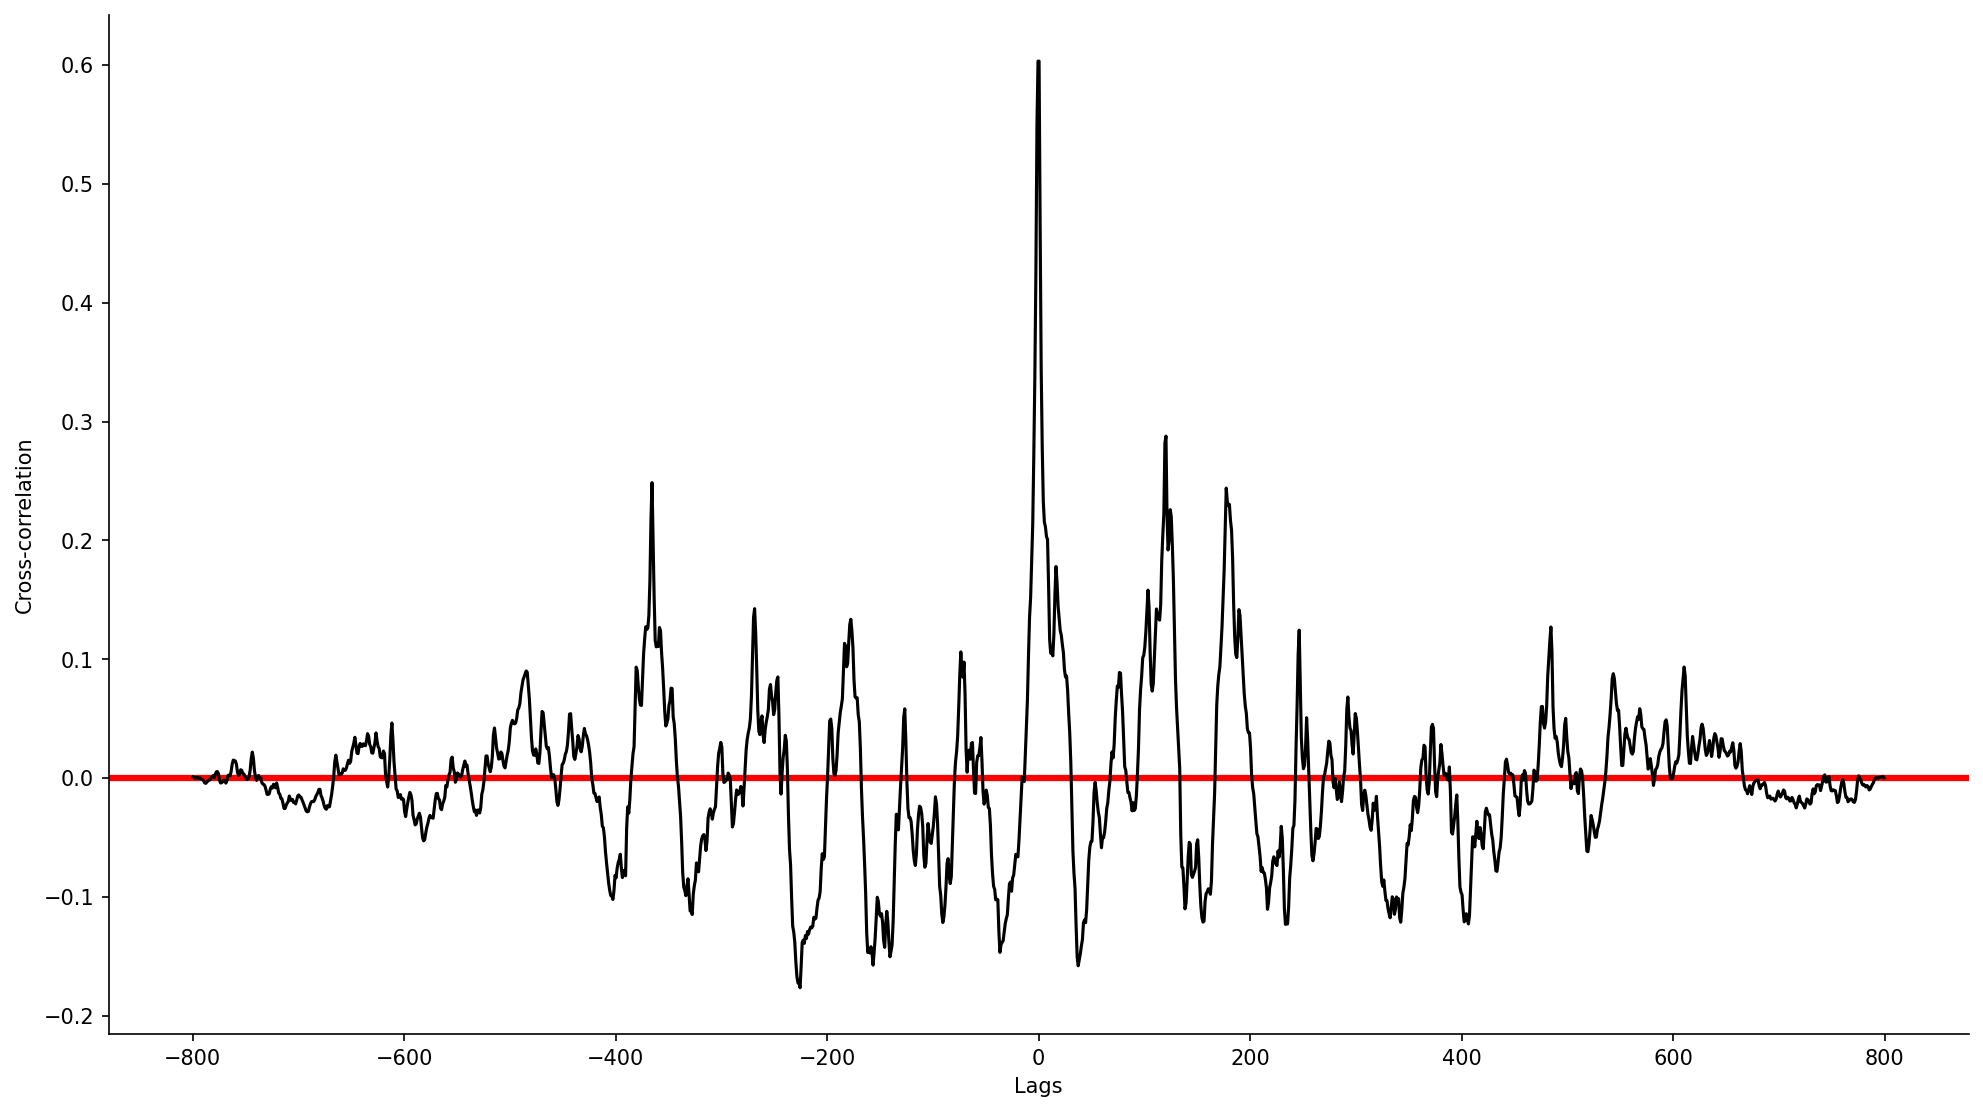

In [18]:
ccf_,_,_= Get_CCF(Splitted_spks,0,1)
plot_ccf(ccf_)

# peak of xcorr ( sn , rest of pop)
# peak of xcorr ( sn , all pop 1st pc)
# decay 

## Glosary:

*Autocorrelation* of the superneuron activity:

> probability of finding a spike at time $t+t^{'}$ given a spike at time t, for some range of lags  $t^{'}$

*Crosscorrelation* between superneurons:

> given that superneuron 1 emit a spike at time $t$ how likely is a spike from superneuron 2 at time $t+t^{'}$


# Sparseness

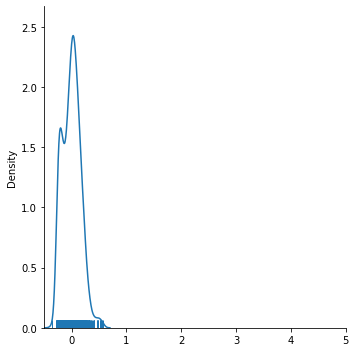

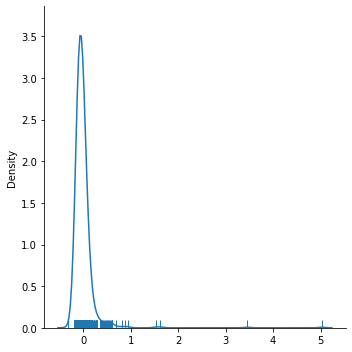

In [66]:
sns.displot(Splitted_sn[4], kind="kde", rug=True)
plt.xlim(-0.5,5)
sns.displot(Splitted_sn[15], kind="kde", rug=True)

In [56]:
kurt_list=[]
for clust in range(n_clusters):
    kurt_list.append(kurtosis(Splitted_sn[clust]))
kurt_arr = np.asarray(kurt_list)

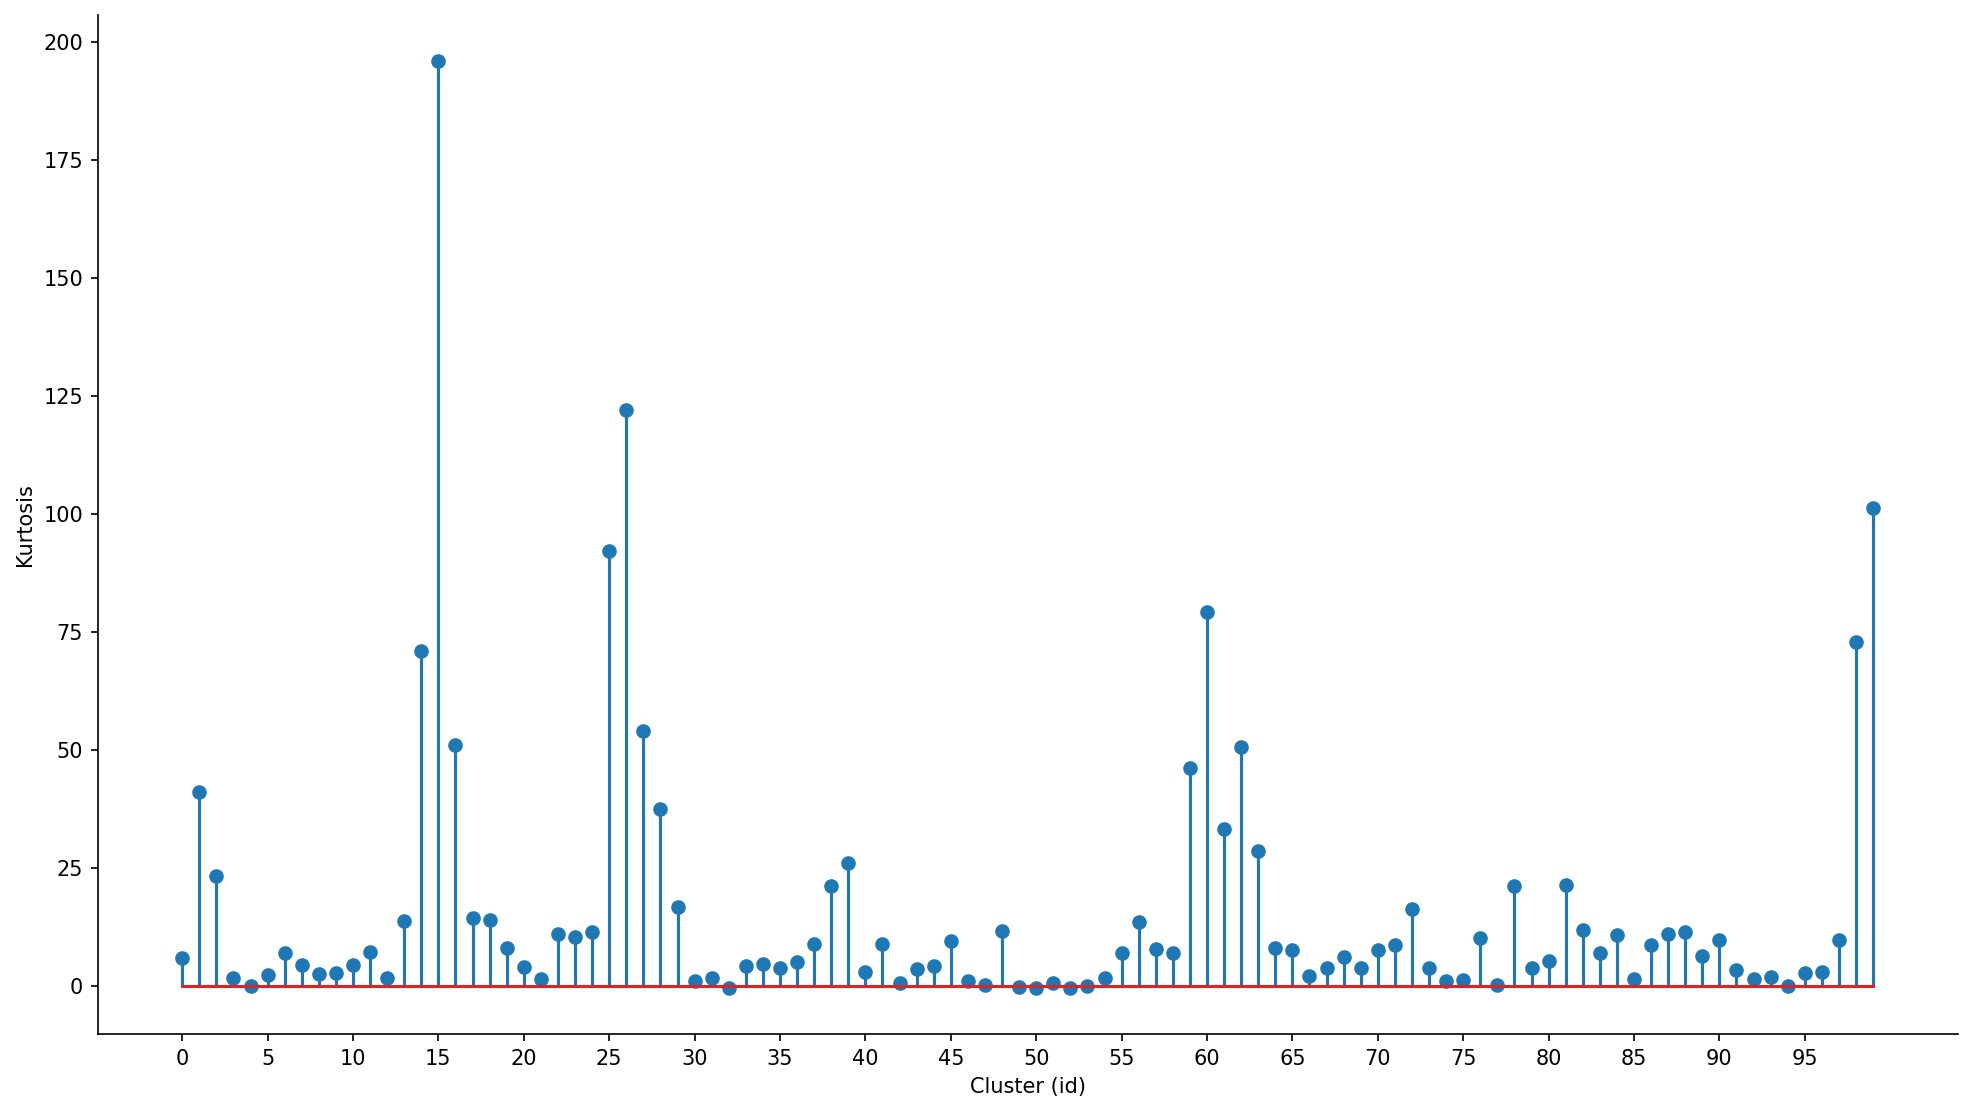

In [62]:
plt.figure(figsize=(16,9), dpi=150)
plt.stem(kurt_arr)
plt.ylabel('Kurtosis')
plt.xlabel('Cluster (id)')
plt.xticks(np.arange(0,100,5))
sns.despine()

* Do skewness

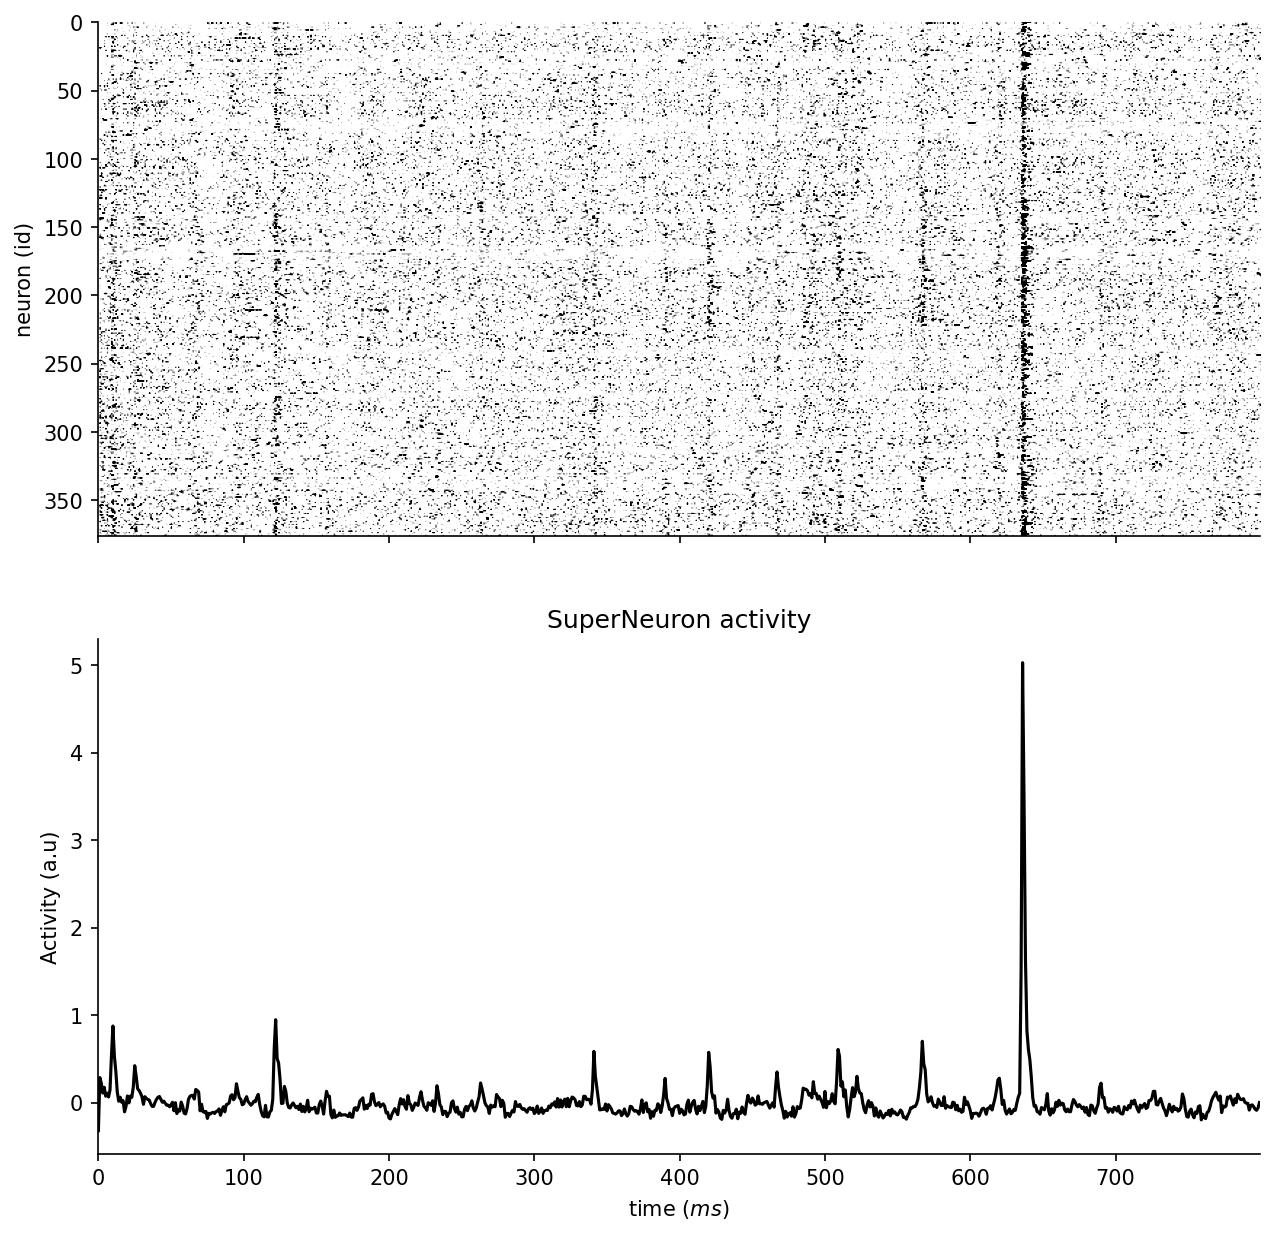

In [63]:
ClusterVisualizer(Splitted_spks[15])

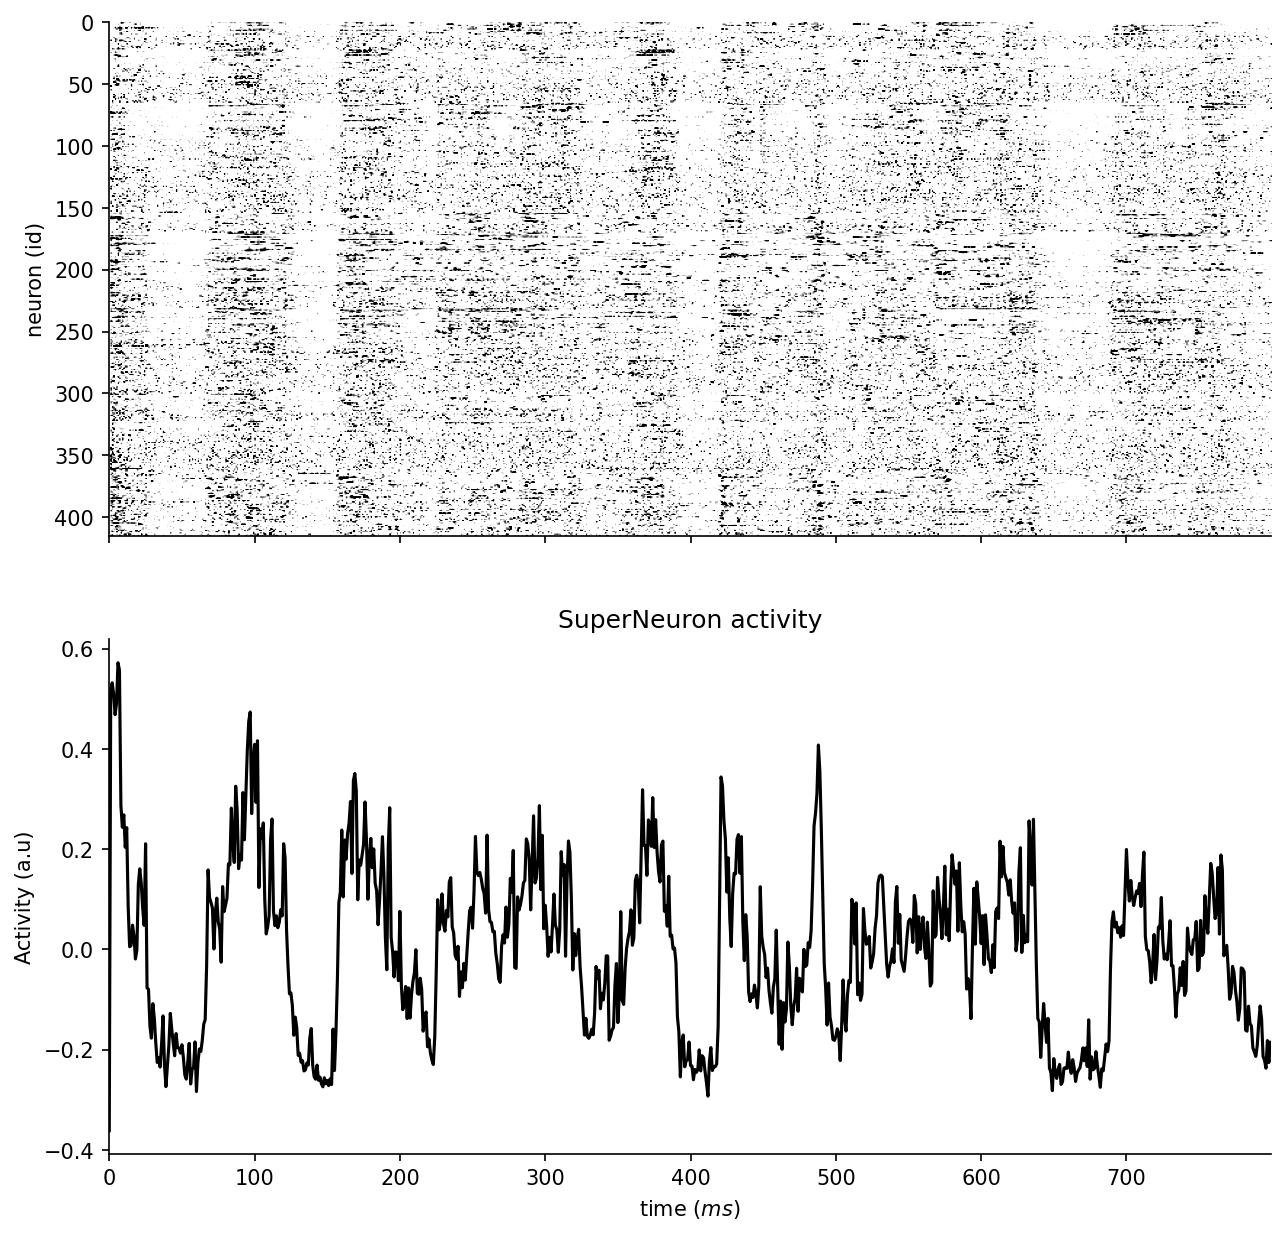

In [64]:
ClusterVisualizer(Splitted_spks[4])

# Spatial distribution exploration

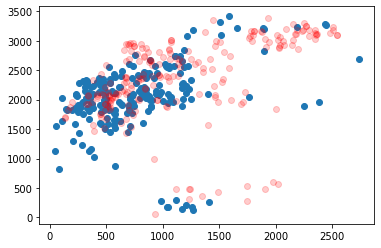

In [38]:
xpos0 = Splitted_xpos[0]
ypos0 = Splitted_ypos[0]
xpos1 = Splitted_xpos[97]
ypos1 = Splitted_ypos[97]
plt.scatter(xpos0,ypos0)
plt.scatter(xpos1,ypos1, color='red', alpha=0.2)

# do mode, and variance

## Needs work -v 

In [31]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

In [32]:
n_comps = 128 # chose to match rastermap output dimension 
pca_128 = PCA(n_components=n_comps).fit(spks)

*loadings* = linear combination of the original variables (aka timepoints in this case) from which the principal components (PCs) are constructed. `pca_128.components_`

In [33]:
U = spks@pca_128.components_.T
U.shape

(42568, 128)

### foor loop to try different number of clusters

* Just to test I took 100 clusters

In [176]:
clusters = [50,100,150,200,300,400]
labels = []
centroids = []
sse = []
sil_score = []
for ncluster in clusters:
    kmeans = KMeans(n_clusters=ncluster, n_init=1, random_state=0).fit(U)
    labels.append(kmeans.labels_)
    centroids.append(kmeans.cluster_centers_)
    sse.append(kmeans.inertia_)

Text(0, 0.5, 'SSE')

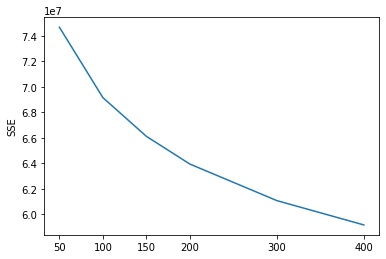

In [177]:
### This makes sense with more models fitted
sse = np.asarray(sse)
fig, ax1 = plt.subplots(1, 1, sharex=True)
clusters_arr = np.asarray(clusters)
ax1.plot(clusters_arr, sse)
ax1.set_xticks(clusters_arr)
ax1.set_ylabel("SSE")
###

# Just neurons sorted by cluster
## Todo: cluster rearrangement 

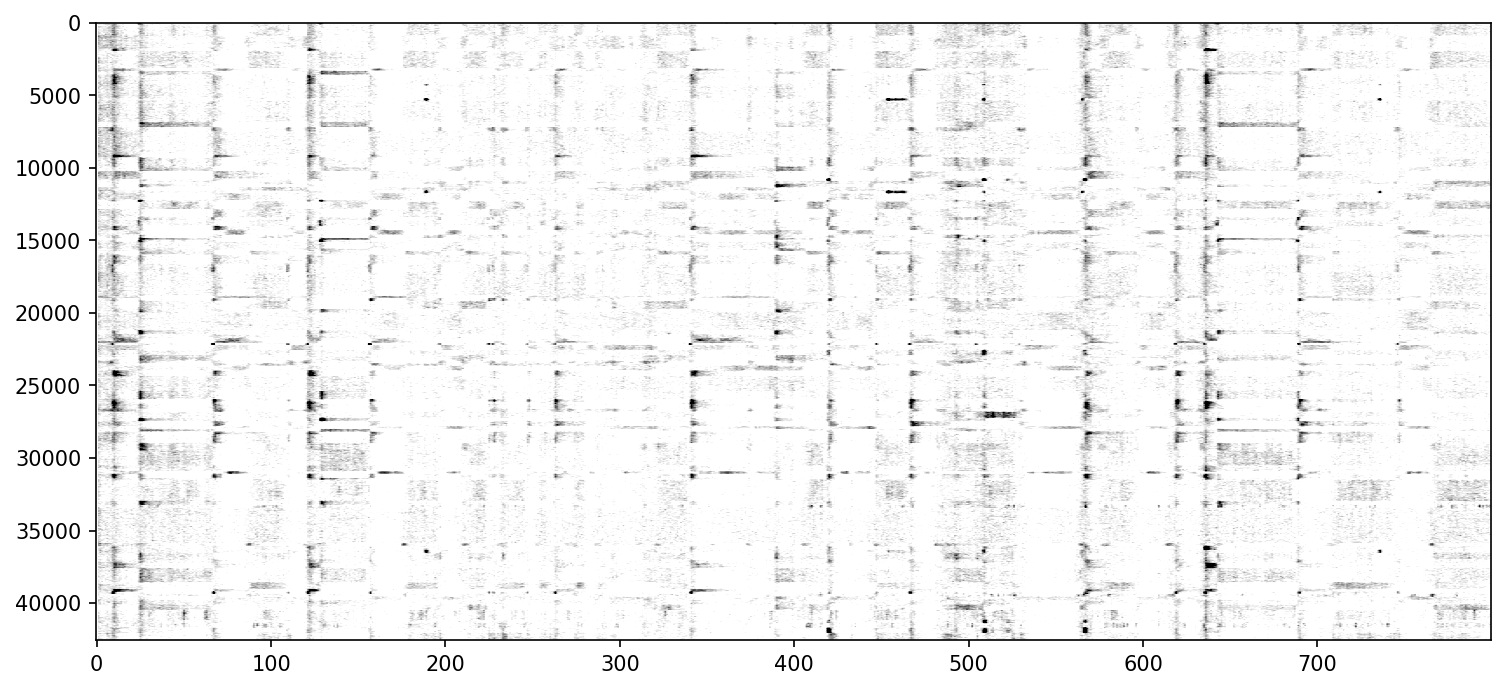

In [178]:
labels = np.asarray(labels[1]) #Getting the labels of the run with 100 clusters
centroids = np.asarray(centroids[1])
sort_idx=np.argsort(labels) 
pc_sort_knn=zscore(spks[sort_idx,xmin:xmax],axis=1)
plt.figure(figsize=(12,12), dpi=150)
plt.subplot(2,1,1)
plt.imshow(pc_sort_knn, vmin=0, vmax=2, cmap='gray_r', aspect='auto')

# Putting similar clusters close each other (?)
I will try to put clusters together by simply doing an agglomerative clustering on the clusters_centers of the Kmeans algo

In [187]:
from sklearn.cluster import AgglomerativeClustering
Cluster_rearrange=AgglomerativeClustering(n_clusters=12).fit(centroids)

In [188]:
order = np.argsort(Cluster_rearrange.labels_)
spks_ordered = np.empty([])
for ord in order:
    sort_idx=np.where(labels==ord)[0]
    spks_ordered = np.append(spks_ordered,spks[sort_idx,xmin:xmax])
spks_ordered = spks_ordered[1:].reshape(-1,800)

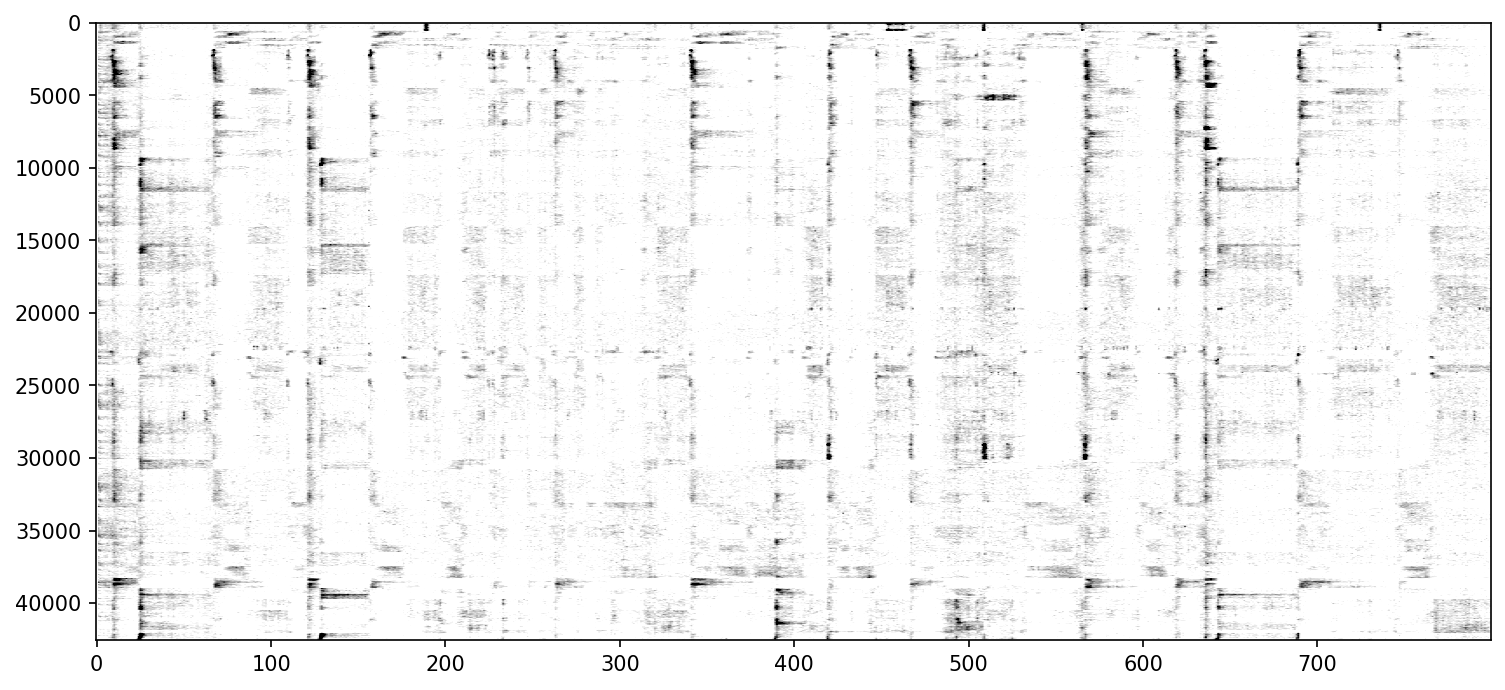

In [189]:
plt.figure(figsize=(12,12), dpi=150)
plt.subplot(2,1,1)
plt.imshow(zscore(spks_ordered,axis=1), vmin=0, vmax=2, cmap='gray_r', aspect='auto')

# Leinden Algo 

## Louvian - Leiden algo

## Louvian

>The Louvain algorithm searches for high-quality clusters by moving individual nodes—for instance individual articles in a citation network—from one cluster to another in such a way that the quality of the clusters is improved as much as possible. When clusters cannot be improved further by moving individual nodes, the Louvain algorithm does something ingenious: it aggregates the network, so that each cluster in the original network becomes a node in the aggregated network. In the aggregated network, the algorithm then starts to move individual nodes from one cluster to another.

--
## BIG FLAW: 

*Sometimes, a node functions as a middle man or a bridge for the rest of its cluster. Without that crucial node, the cluster would not be connected anymore. Since the Louvain algorithm keeps moving nodes from one cluster to another, at some point it may move the crucial node to a different cluster, thereby breaking the connectivity of the original cluster*

## Leiden

Leiden algorithm is able to split clusters instead of only merging them, as is done by the Louvain algorithm. By splitting clusters in a specific way, the Leiden algorithm guarantees that clusters are well-connected. Moreover, the algorithm guarantees more than this: if we run the algorithm repeatedly, we eventually obtain clusters that are subset optimal.

*This means that it is impossible to improve the quality of the clusters by moving one or more nodes from one cluster to another*

Rather than continuously checking for all nodes in a network whether they can be moved to a different cluster, as is done in the Louvain algorithm, the Leiden algorithm performs this check only for so-called unstable nodes. As a result, the Leiden algorithm does not only find higher quality clusters than the Louvain algorithm, it also does so in much less time.

In [194]:
import scanpy as sc
adata = sc.AnnData(spks)
sc.tl.pca(adata, n_comps=128)
sc.pp.neighbors(adata, n_neighbors=100, n_pcs=128) #matching previous hyperparameters
sc.tl.leiden(adata, resolution=1)
leiden_labels = adata.obs['leiden'].astype(int)

In [198]:
print(f'number of clusters by leiden algo: { len(np.unique(leiden_labels))}')

number of clusters by leiden algo: 13


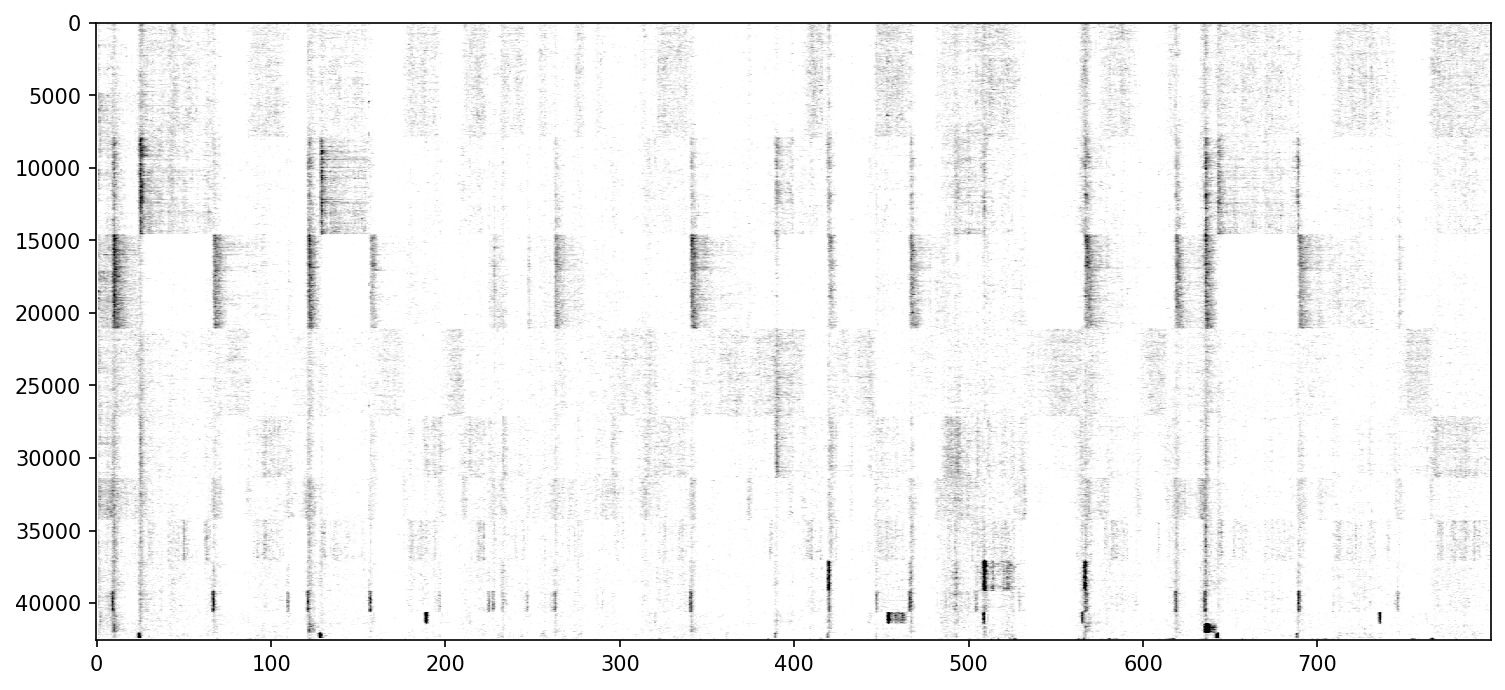

In [195]:
sort_idx=np.argsort(leiden_labels) 
pc_sort_leid=zscore(spks[sort_idx,xmin:xmax],axis=1)
plt.figure(figsize=(12,12), dpi=150)
plt.subplot(2,1,1)
plt.imshow(pc_sort_leid, vmin=0, vmax=2, cmap='gray_r', aspect='auto')